In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

n = 5
states = [(i, j) for i in range(n) for j in range(n)]
state_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for s, i in state_idx.items()}

# states
blue_state = (4, 0) # start
red_states = {(2, 0), (2, 1), (2, 3), (2, 4)}
terminal_states = {(0, 0), (0, 4)}

# actions
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
action_symbols = ['↑', '↓', '←', '→']

In [ ]:
def in_grid(state):
  row, col = state
  return 0 <= row < n and 0 <= col < n

def ns_reward(current_state, action):
  curr_row, curr_col = current_state
  dr, dc = actions[action]

  next_row, next_col = curr_row + dr, curr_col + dc

  # check if out of grid
  if not in_grid((next_row, next_col)):
    reward = -1
    return current_state, reward, False

  next_state = (next_row, next_col)

  if next_state in terminal_states:
    reward = 0
    return next_state, reward, True
  elif next_state in red_states:
    reward = -20
    return blue_state, reward, False
  else:
    reward = -1
    return next_state, reward, False

def select_action(Q, state, eps):
  state_index = state_idx[state]

  if np.random.rand() < eps:
      return np.random.randint(len(actions)) # explore
  else:
      if np.all(Q[state_index, :] == Q[state_index, 0]):
          return np.random.randint(len(actions)) # choose randomly among ties
      else:
          return np.argmax(Q[state_index, :])

In [ ]:
def plot_trajectory(Q, title):
  fig, ax = plt.subplots(figsize=(6, 6))
  current_state = blue_state # initialize starting point
  trajectory = [current_state]
  steps = 0

  #  generate trajectory until the agent reaches a terminal state
  while current_state not in terminal_states:
    action = np.argmax(Q[state_idx[current_state], :]) # get best action
    next_state, _, is_terminal = ns_reward(current_state, action)
    current_state = next_state # move to next state
    trajectory.append(current_state)

    # stop if terminal state is reahed
    if current_state in terminal_states:
      is_terminal = True
      break

    steps += 1

  cmap = {
      'blue': 'blue',
      'red': 'red',
      'terminal': 'black',
      'regular': 'white'
  }

  grid_colors = np.full((n, n), 'white', dtype=object)

  # assign color to grid based on state
  for row in range(n):
    for col in range(n):
      state = (row, col)
      if state in red_states:
        grid_colors[row, col] = 'red'
      elif state in terminal_states:
        grid_colors[row, col] = 'black'
      elif state == blue_state:
        grid_colors[row, col] = 'blue'
      else:
        grid_colors[row, col] = 'white'

      rect = plt.Rectangle((col - 0.5, row - 0.5), 1, 1, facecolor=grid_colors[row, col], edgecolor='gray', linewidth=1)
      ax.add_patch(rect)

  path_rows = [s[0] for s in trajectory]
  path_cols = [s[1] for s in trajectory]

  ax.plot(path_cols, path_rows, marker='s', color='green', linewidth=1, markersize=8, label='Trajectory')

  # highlight startnig point
  ax.plot(blue_state[1], blue_state[0], 's', markersize=8, color='darkblue', label='Start')

  # highlight end point
  if trajectory and trajectory[-1] in terminal_states:
    end_state = trajectory[-1]
    ax.plot(end_state[1], end_state[0], 's', markersize=8, color='darkred', label='Terminal (Black)')

  ax.invert_yaxis()
  ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
  ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
  ax.grid(which='minor', linestyle='-', linewidth=0.5, color='black')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title, fontsize=10)

  plt.title(title, fontsize=10)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

  trajectory = np.array(trajectory)

#### **SARSA**

In [ ]:
alpha = 0.1
reward_discount = 0.95
eps = 0.05
num_episodes = 5000

def sarsa():
  Q = np.zeros((len(states), len(actions)))
  rewards = []

  for episode in range(num_episodes):
    current_state = blue_state
    total_reward = 0
    terminal = False

    # select initial action
    action = select_action(Q, current_state, eps)

    while not terminal:
      next_state, reward, is_terminal = ns_reward(current_state, action)
      total_reward += reward

      # compute target
      if is_terminal:
        target = reward
      else:
        next_action = select_action(Q, next_state, eps)
        target = reward + reward_discount * Q[state_idx[next_state], next_action]

      # uodate Q-value using SARSA update rule
      old_Q = Q[state_idx[current_state], action]
      Q[state_idx[current_state], action] = old_Q + alpha * (target - old_Q)

      current_state = next_state # move to bext state
      if not is_terminal:
        action = next_action
      terminal = is_terminal

    rewards.append(total_reward)

  return Q, rewards


In [ ]:
sarsa_Q, sarsa_rewards = sarsa()

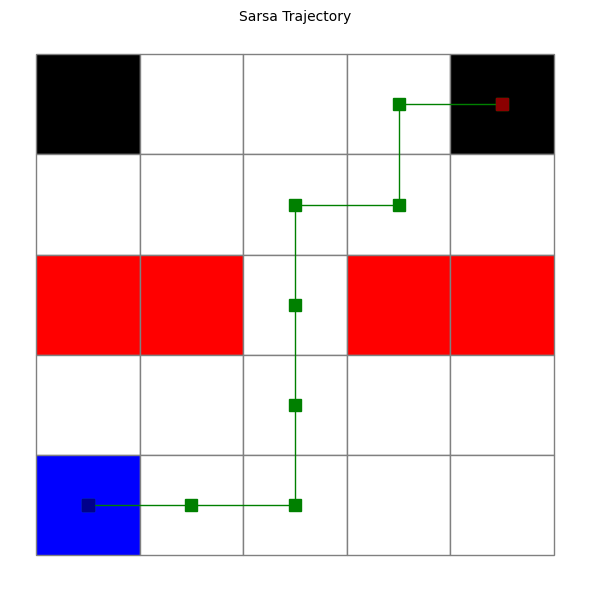

In [ ]:
plot_trajectory(sarsa_Q, 'Sarsa Trajectory')

#### **Q-Learning**

In [ ]:
def qlearn():
  Q = np.zeros((len(states), len(actions)))
  rewards = []

  for episode in range(num_episodes):
    current_state = blue_state
    total_reward = 0
    terminal = False

    while not terminal:
      # select action
      action = select_action(Q, current_state, eps)
      next_state, reward, is_terminal = ns_reward(current_state, action)
      total_reward += reward

      old_Q = Q[state_idx[current_state], action] # current Q-value

      # compute target
      if is_terminal:
        target = reward
      else:
        target = reward + reward_discount * np.max(Q[state_idx[next_state], :]) # use max value of next state

      # update Q-value
      Q[state_idx[current_state], action] = old_Q + alpha * (target - old_Q)

      current_state = next_state
      terminal = is_terminal

    rewards.append(total_reward)

  return Q, rewards

In [ ]:
qlearn_q, qlearn_rewards = qlearn()

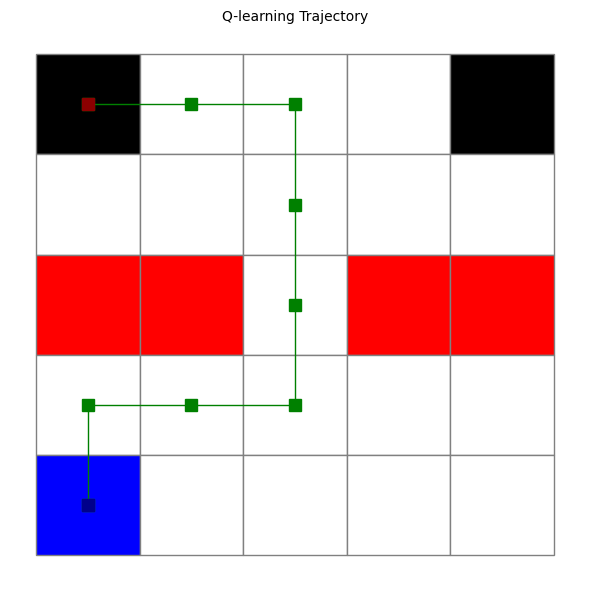

In [ ]:
plot_trajectory(qlearn_q, 'Q-learning Trajectory')

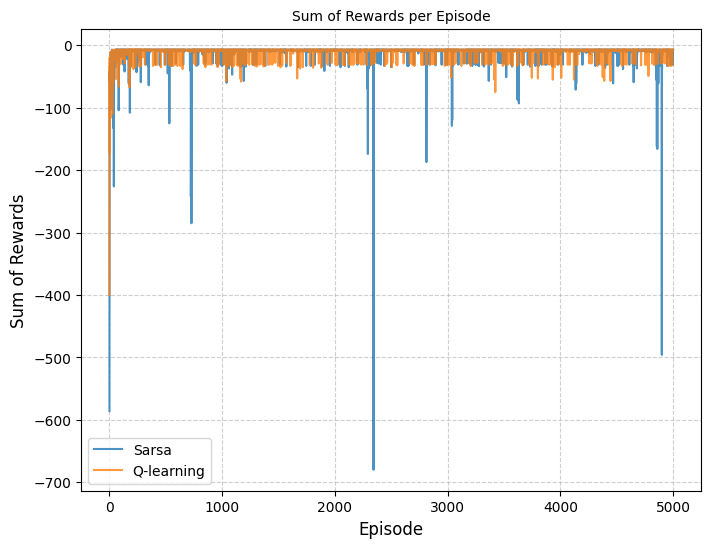

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(sarsa_rewards, label='Sarsa', alpha=0.8)
plt.plot(qlearn_rewards, label='Q-learning', alpha=0.8)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Sum of Rewards', fontsize=12)
plt.title('Sum of Rewards per Episode', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()